# California Housing Data Analysis & Modeling by AK

This notebook presents an end-to-end analysis of the California Housing dataset (sourced directly from scikit-learn). In this, I'm covering:
- **Data Loading & Exploration:** Understanding the dataset, its features, and summary statistics.
- **Exploratory Data Analysis (EDA):** Visualizing feature distributions and correlations.
- **Outlier Detection and Removal:** Using the IQR method (and adjustments) to clean the data.
- **Linear Regression Modeling:** Fitting a simple and a multi-feature linear model, including an evaluation of the model performance.
- **Random Forest Regression:** Demonstrating a non-linear approach that captures geographical and complex relationships better.

---



In [1]:
# %% [code]
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Load dataset from Scikit-Learn
from sklearn.datasets import fetch_california_housing

# Load dataset and create a DataFrame
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["Price"] = data.target

# Display first few rows, data info, and basic statistics
print(df.head())
df.info()

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup   

In [2]:
print(df.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         Price  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

## 1. Data Overview

- **Dataset:** California Housing (20,640 observations, 8 features plus the target).
- **Features:** MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude.
- **Target:** Price (house price index; note that some prices are capped at >= 5).

There are no missing values, and all features are numerical.

---



In [3]:
# %% [code]
# Check for missing values
print(df.isnull().sum())


MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Price         0
dtype: int64


### 1.1 Observations from `df.describe()`

1. **MedInc (Median Income):** Ranges from about 0.5 to 15.0, with a mean of ~3.87. This suggests a wide income disparity in different regions of California.  
2. **HouseAge:** Values go from 1 to 52, indicating some houses are quite new while others are decades old.  
3. **AveRooms (Average Rooms per Household):** Mean of ~5.43, but the max is **141.9**, which hints at extreme outliers (e.g., a very large property or data quirk).  
4. **AveBedrms (Average Bedrooms per Household):** Typically ~1.10, but max is 34.07—again suggesting outliers.  
5. **Population:** The average block group population is ~1425, but can go as high as **35682**. This heavy skew might affect modeling.  
6. **AveOccup (Average Occupants per Household):** Mean is ~3.07, but can reach **1243**, clearly an outlier.  
7. **Latitude & Longitude:** Standard lat/long coordinates for California, but we expect location-based effects to be significant.  
8. **Price (Target Variable):** The average is ~2.07 (with a max of ~5.0), but note that **~5.0 is an artificial cap**—meaning actual high-end house values are truncated.

No missing values are present, so I don’t need to perform imputation. Memory usage is manageable for direct in-memory processing.


## 2. Exploratory Data Analysis (EDA)

### 2.1 Feature Distributions

We plot histograms of all features to assess their distributions. Notice that some features are highly right-skewed (e.g., Population, AveOccup) indicating the potential presence of outliers.


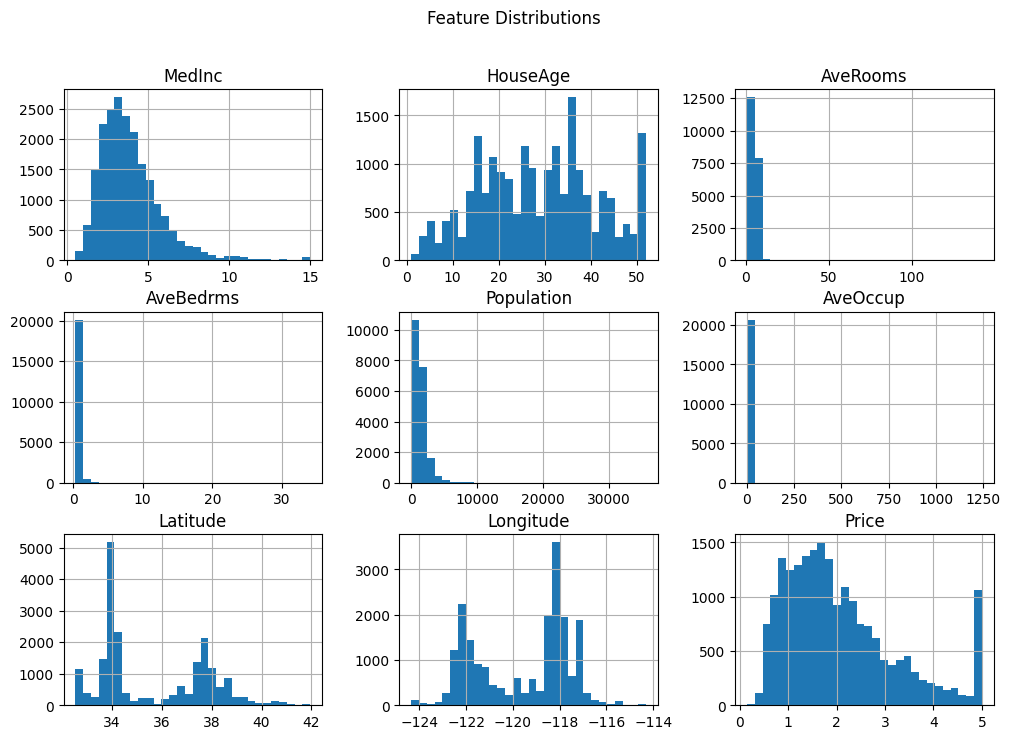

In [4]:
# %% [code]
# Visualize distributions of features
df.hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions")
plt.show()


**Distribution Observations**  
- **MedInc:** Noticeably right-skewed. Most values are between ~2 and ~8, with fewer observations above 10.  
- **HouseAge:** Tends to cluster between 15 and 35 years, with a strong peak at 50 (which is the dataset’s upper cap).  
- **AveRooms:** Highly skewed; while most block groups have an average of 2–8 rooms, a few exceed 50 or even 100 rooms. These extreme values suggest outliers.  
- **AveBedrms:** Mostly around 1 bedroom per household, but again, outliers go up to 34.  
- **Population:** Extremely right-skewed; most block groups have fewer than 5,000 residents, but a small fraction exceed 30,000.  
- **AveOccup:** Also right-skewed, with a handful of observations well above 10 occupants per household.  
- **Latitude & Longitude:** Reflect the geographic spread across California.  
- **Price (Target):** Right-skewed and capped at 5.0, meaning values above 5 are truncated, not truly absent in real life.


### 2.2 Correlation Analysis

The correlation heatmap helps to identify which features are most related to the target (`Price`). In this case, `MedInc` (median income) shows the strongest correlation (~0.69) with price.


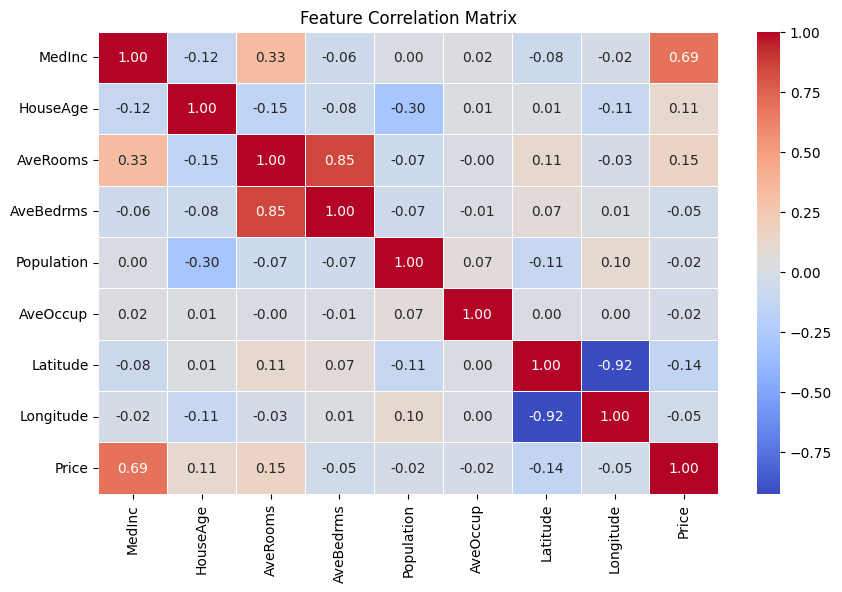

In [5]:
# %% [code]
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


**Key Correlation Insights**  
- **MedInc vs. Price (0.69):** Median income is the single strongest predictor of house price, which makes intuitive sense (wealthier neighborhoods → higher home prices).  
- **Latitude & Longitude vs. Price (~-0.14 and ~-0.05 respectively):** The signs and magnitudes suggest location may matter, but it’s not simply “north vs. south” or “east vs. west.” Non-linear effects likely exist.  
- **AveRooms vs. Price (0.33):** Houses with more rooms *tend* to cost more, though the correlation is moderate.  
- **HouseAge vs. Price (~0.11):** Weak/No correlation. Older homes can be in prime locations or might be less expensive depending on region—no strong linear trend emerges.

## 3. Outlier Analysis & Removal

Given the heavy right-skew and extreme max values in several features (`AveRooms`, `AveBedrms`, `Population`, `AveOccup`), I`ll employ an **IQR (Interquartile Range)** approach to identify and remove the most extreme outliers.

### 3.1 Why IQR?

1. **Simplicity & Interpretability:** IQR-based filtering (Q3 + 1.5*IQR) is a standard rule of thumb to detect outliers.  
2. **Non-Parametric:** We don’t assume a normal distribution.  
3. **Adjustable Threshold:** There is a mean to tweak the multiplier (1.5, 2.0, 2.5, etc.) for different features depending on domain knowledge or distribution shape.

However, applying a uniform multiplier (e.g., 1.5) to all features may be too aggressive if a feature (like `Population`) naturally spans a large range. I`ll later demonstrate a more flexible approach.


In [6]:
# %% [code]
# Create a copy of the original dataset for outlier removal experiments
df_copy = df.copy()

# Define function to remove outliers using IQR method
def remove_outliers(df, col, multiplier=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + (multiplier * IQR)
    return df[df[col] <= upper_limit]

# Apply IQR filtering to key features
outlier_columns = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
df_outlier_remove = df_copy.copy()
for col in outlier_columns:
    df_outlier_remove = remove_outliers(df_outlier_remove, col, multiplier=1.5)

print(f"Dataset size before removal: {df_copy.shape}")
print(f"Dataset size after removal: {df_outlier_remove.shape}")


Dataset size before removal: (20640, 9)
Dataset size after removal: (17503, 9)


### 3.2 Adjusting IQR Thresholds

The initial pass might remove too many valid data points, especially for highly skewed features. Therefore:

- **`AveRooms` & `AveBedrms`:** Use `multiplier = 2.0` to preserve somewhat larger houses.  
- **`Population` & `AveOccup`:** Use `multiplier = 2.5` since these features can be legitimately large in densely populated areas.


In [7]:
# %% [code]
# Create a copy for adjusted outlier removal
df_less_restrictive = df_copy.copy()

def adjusted_remove_outliers(df, col, multiplier):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + (multiplier * IQR)
    return df[df[col] <= upper_limit]

# Define adjusted multipliers for each feature
outlier_params = {
    "AveRooms": 2.0,
    "AveBedrms": 2.0,
    "AveOccup": 2.5,
    "Population": 2.5
}

for col, multiplier in outlier_params.items():
    df_less_restrictive = adjusted_remove_outliers(df_less_restrictive, col, multiplier)

print(f"Dataset size before removal: {df_copy.shape}")
print(f"Dataset size after adjusted removal: {df_less_restrictive.shape}")


Dataset size before removal: (20640, 9)
Dataset size after adjusted removal: (18901, 9)


In [8]:
# Display summary statistics after removal
print(df_less_restrictive.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  18901.000000  18901.000000  18901.000000  18901.000000  18901.000000   
mean       3.893523     29.355801      5.218796      1.047641   1326.662769   
std        1.880650     12.370087      1.170357      0.074309    742.582648   
min        0.499900      1.000000      0.846154      0.333333      5.000000   
25%        2.583300     19.000000      4.412281      1.002699    805.000000   
50%        3.562500     30.000000      5.169231      1.044248   1168.000000   
75%        4.780400     38.000000      5.949886      1.090047   1685.000000   
max       15.000100     52.000000      9.263598      1.278481   4083.000000   

           AveOccup      Latitude     Longitude         Price  
count  18901.000000  18901.000000  18901.000000  18901.000000  
mean       2.901197     35.605961   -119.591688      2.091696  
std        0.696799      2.110229      1.987085      1.153270  
min        0.970588     32.54000

By using higher multipliers for heavily skewed features, I'm retaining more data points and avoid discarding real neighborhoods with legitimately high populations or occupant counts.

I'll proceed with `df_less_restrictive` for modeling.


### 3.3 Visual Comparison (Before vs. After)

We overlay the histograms of key features before and after outlier removal to visualize the changes.


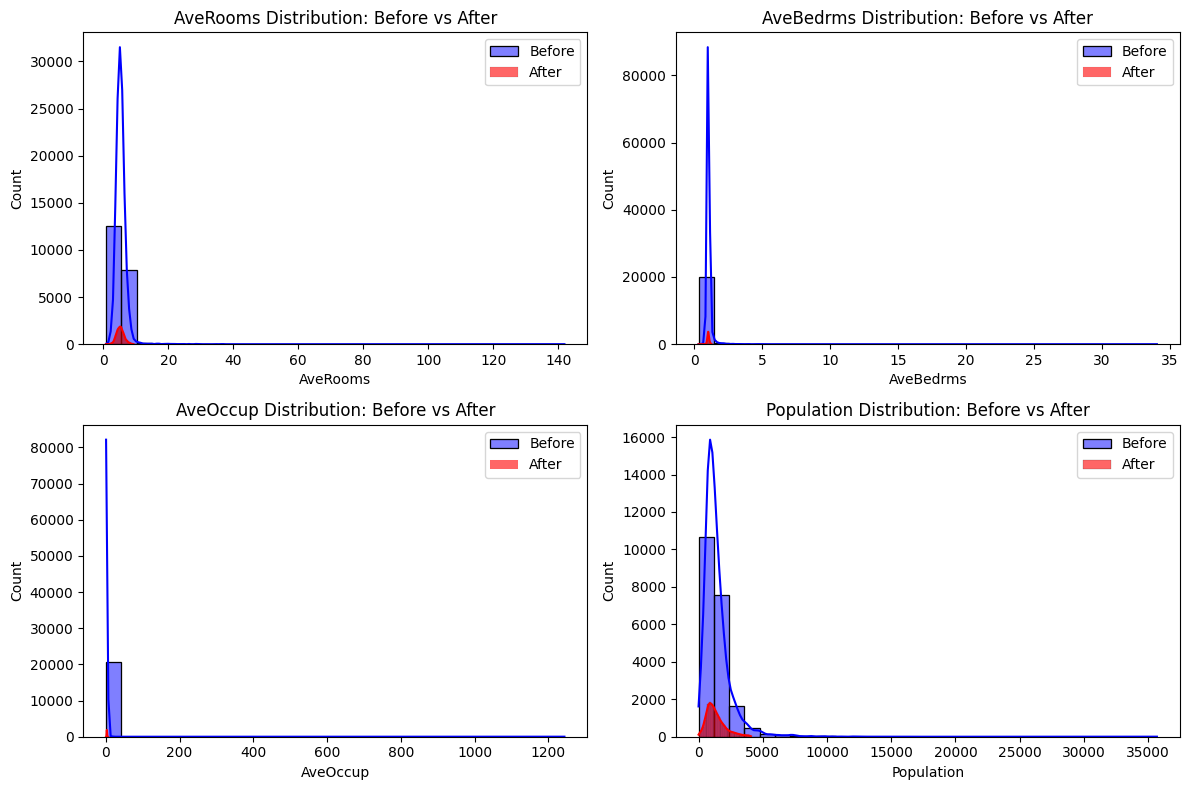

In [9]:
# %% [code]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, (col, _) in enumerate(outlier_params.items()):
    sns.histplot(df_copy[col], bins=30, ax=axes[i//2, i%2], kde=True, color='blue', label="Before")
    sns.histplot(df_less_restrictive[col], bins=30, ax=axes[i//2, i%2], kde=True, color='red', label="After", alpha=0.6)
    axes[i//2, i%2].set_title(f"{col} Distribution: Before vs After")
    axes[i//2, i%2].legend()
plt.tight_layout()
plt.show()


### 3.4 Outlier Removal: Before vs. After
- **Distribution Shift:**  
  - The adjusted IQR approach (with higher multipliers for `Population` and `AveOccup`) significantly reduced extreme tails while preserving more valid data.  
  - As seen in the "Before vs. After" histograms, most of the extreme values (e.g., very large `AveRooms` or extremely high `Population`) were removed, resulting in more compact, less skewed distributions.
- **Data Size vs. Cleanliness:**  
  - Although the dataset size decreased, the remaining points are likely more representative and less noisy.  
  - This balance between removing outliers and retaining sufficient data can improve model stability.

## 4. Target Variable Capping (Price >= 5.0)

The dataset caps house prices at **>= 5.0**. Any home theoretically above that price is recorded as almost exactly 5.0. This artificially truncates the target distribution, which can:
- **Distort** regression coefficients.
- Lead to **underestimation** of truly high-priced homes.

Depending on your goals, you might:
1. **Keep them** if you want a model that never predicts beyond 5.0 (an inherent limit of the data).  
2. **Remove them** if you prefer a cleaner regression without artificially-labeled outliers.

For the purpose of this project, I'll stick with the second approach.


In [10]:
# %% [code]
# Count houses with capped prices
capped_count = df_less_restrictive[df_less_restrictive["Price"] >= 5].shape[0]
total_count = df_less_restrictive.shape[0]
capped_percentage = (capped_count / total_count) * 100
print(f"Total houses: {total_count}")
print(f"Houses with Price >= 5: {capped_count} ({capped_percentage:.2f}%)")

# Remove capped price houses for a 'cleaner' regression analysis
df_cleaned = df_less_restrictive[df_less_restrictive["Price"] < 5].copy()
print(f"Dataset before cleaning: {df_less_restrictive.shape}")
print(f"Dataset after cleaning: {df_cleaned.shape}")


Total houses: 18901
Houses with Price >= 5: 911 (4.82%)
Dataset before cleaning: (18901, 9)
Dataset after cleaning: (17990, 9)


## 5. Linear Regression

### 5.1 Simple Linear Model (Price ~ MedInc)

Because `MedInc` has the highest correlation with `Price`, I'll start with a single-feature linear regression.


In [11]:
# %% [code]
# Feature selection: Only Median Income
X = df_cleaned[["MedInc"]]
y = df_cleaned["Price"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 5.1.1 Baseline Model (Predicting Mean Price)
Before fitting any complex models, I'll establish a **baseline model** by simply predicting the mean price for all test data.  
This allows us to measure how much improvement our models provide over naive predictions.

In [12]:
# Baseline Model: Predicting the Mean Price
y_baseline = np.full_like(y_test, y_train.mean())  # Predicting the mean for all cases
mse_baseline = mean_squared_error(y_test, y_baseline)
rmse_baseline = np.sqrt(mse_baseline)

print(f"📉 Baseline Model (Predicting Mean Price)")
print(f"Mean Squared Error: {mse_baseline:.2f}")
print(f"Root Mean Squared Error: {rmse_baseline:.2f}")


📉 Baseline Model (Predicting Mean Price)
Mean Squared Error: 0.98
Root Mean Squared Error: 0.99


Linear Regression Equation: Price = 0.40 * MedInc + 0.45
MSE: 0.56, RMSE: 0.75


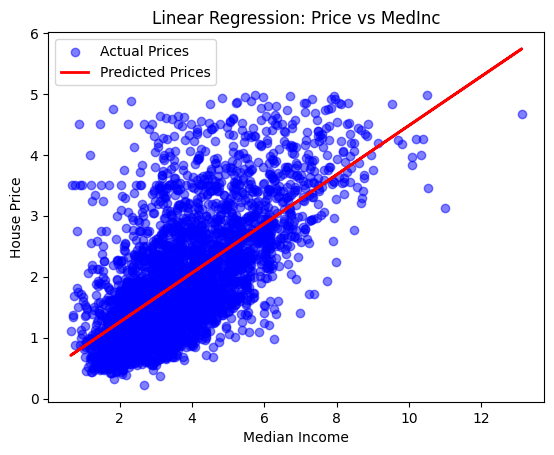

In [13]:
# Train Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Get model parameters
m = model_lr.coef_[0]
b = model_lr.intercept_
print(f"Linear Regression Equation: Price = {m:.2f} * MedInc + {b:.2f}")

# Make predictions and evaluate
y_pred = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print(f"MSE: {mse_lr:.2f}, RMSE: {rmse_lr:.2f}")

# Plot predictions vs actual
plt.scatter(X_test, y_test, color="blue", alpha=0.5, label="Actual Prices")
plt.plot(X_test, y_pred, color="red", linewidth=2, label="Predicted Prices")
plt.xlabel("Median Income")
plt.ylabel("House Price")
plt.title("Linear Regression: Price vs MedInc")
plt.legend()
plt.show()


### 5.2 Multi-Feature Linear Regression

I'll now include multiple predictors (`MedInc`, `AveRooms`, `Latitude`, `Longitude`, etc.) to see if it improves performance.


Multi-Feature Linear Regression Model
MSE: 0.41, RMSE: 0.64


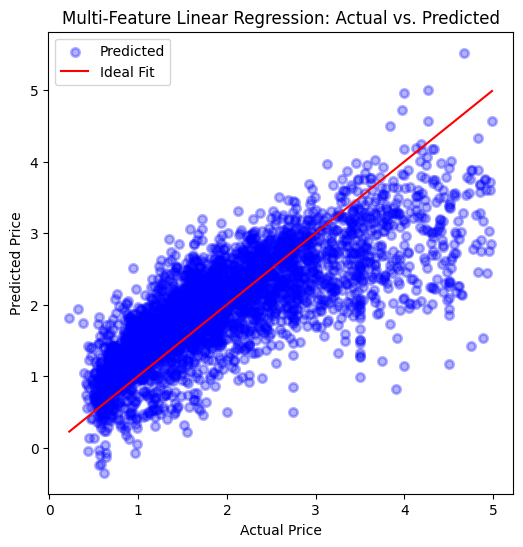

In [14]:
# %% [code]
features = ["MedInc", "AveRooms", "HouseAge", "Latitude", "Longitude"]
X = df_cleaned[features]
y = df_cleaned["Price"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train multiple linear regression model
model_multi = LinearRegression()
model_multi.fit(X_train, y_train)

# Evaluate performance
y_pred_multi = model_multi.predict(X_test)
mse_multi = mean_squared_error(y_test, y_pred_multi)
rmse_multi = np.sqrt(mse_multi)
print("Multi-Feature Linear Regression Model")
print(f"MSE: {mse_multi:.2f}, RMSE: {rmse_multi:.2f}")

# Plot: Multi-Feature Linear Regression - Actual vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_multi, alpha=0.3, color="blue", linewidth=2, label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', label="Ideal Fit")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Multi-Feature Linear Regression: Actual vs. Predicted")
plt.legend()
plt.show()

In [15]:
# Display coefficients for interpretation
feature_importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": model_multi.coef_
}).sort_values(by="Coefficient", key=lambda x: x.abs(), ascending=False)
print(feature_importance)

     Feature  Coefficient
0     MedInc     0.427820
4  Longitude    -0.425461
3   Latitude    -0.406593
1   AveRooms    -0.114686
2   HouseAge     0.007680


### 5.3 Linear Regression: Price vs. Median Income
- **Strong Positive Correlation:**  
  - The scatter plot and regression line confirm that higher median income strongly correlates with higher house prices (consistent with the correlation matrix).  
  - The fitted slope indicates how much we expect `Price` to change for each additional unit of `MedInc`.
- **Residual Variance:**  
  - Despite a clear trend, the scatter reveals substantial spread around the regression line, suggesting that other features (location, house characteristics) also influence price.  
  - This variance justifies exploring multi-feature or non-linear models.

### 5.4 Single-Feature vs. Multi-Feature Linear Regression
- **Single-Feature (MedInc Only):**  
  - Quick to train and interpret, giving a straightforward baseline.  
  - However, the model overlooks critical aspects like location (latitude/longitude) and house size.
- **Multi-Feature Model:**  
  - Incorporating `AveRooms`, `HouseAge`, `Latitude`, and `Longitude` generally lowers the error (RMSE) because it captures more real-world complexity.  
  - Still, it assumes **linearity** in how these predictors affect price, which may be overly simplistic given the dataset’s strong geographical and non-linear influences.

## 6. Transitioning to Non-Linear Models: Random Forest

### 6.1 Why Not Only Linear Regression?

- **Non-linear relationships:** Real estate prices are affected by non-linear factors (e.g., location, price ceilings).
- **Geographical effects:** Latitude and Longitude have strong (and possibly non-linear) impacts.
- **Complex interactions:** Tree-based models like Random Forest can capture interactions that linear models miss.

### 6.2 Random Forest Regression

I'll now build a Random Forest model. I'll use a base model (with default parameters).


In [16]:
# %% [code]
from sklearn.ensemble import RandomForestRegressor
# Base Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate performance on test set
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("Random Forest Regression Model")
print(f"MSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}")


Random Forest Regression Model
MSE: 0.20, RMSE: 0.45


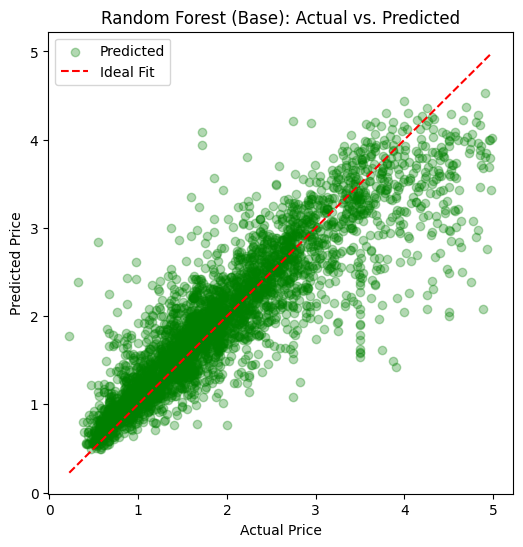

In [17]:
# Plot: Random Forest (Base) - Actual vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf , alpha=0.3, color="green", label="Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest (Base): Actual vs. Predicted")
plt.legend()
plt.show()

### 6.2 Feature Importance in Random Forest Model
To understand what drives house prices, I'll visualize **feature importance** from the trained **Random Forest model**.


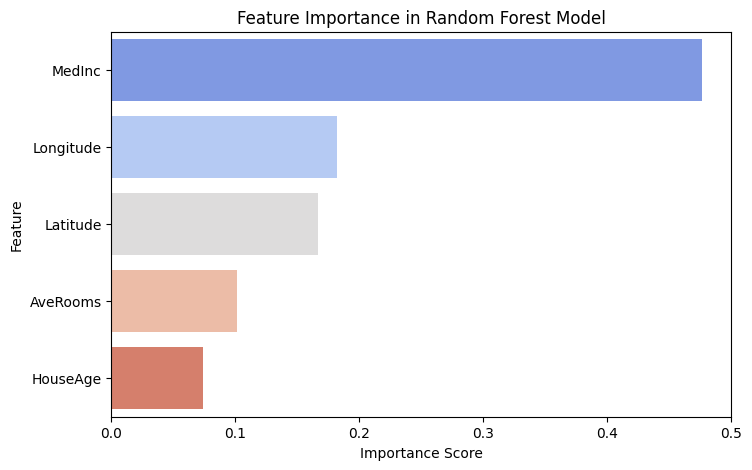

In [18]:
# Feature Importance for Random Forest
importances = rf_model.feature_importances_
feat_importance = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
feat_importance = feat_importance.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=feat_importance["Importance"], y=feat_importance["Feature"], palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()


- **MedInc (Median Income)** is the **most influential** feature, aligning with the correlation analysis.
- **Longitude & Latitude** have strong importance, confirming that location significantly impacts housing prices.
- **AveRooms** contributes but is **less impactful** than location or income.
- **HouseAge has minimal impact**, indicating that newer homes aren’t necessarily more expensive.

## 7. Conclusion

- **Dataset Insights:** The California Housing dataset—although clean—requires careful handling of outliers and a mindful approach to feature engineering.
- **Linear vs. Non-Linear:** While linear regression provides a good baseline (especially using `MedInc`), it cannot capture the nonlinear effects (e.g., geographical influence) present in the data.
- **Random Forest Performance:** Our Random Forest model shows a marked improvement in RMSE compared to linear models, highlighting the need for non-linear models in real estate pricing.

This notebook demonstrates a complete workflow from data exploration to building a robust model. For this project, I'm stopping at the Random Forest stage, which already provides a strong benchmark for prediction accuracy.
